In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import k0, iti0k0
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from new_struct.well import Well as NewWell

In [179]:
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
n_stehf = 10
xwd = 2.5
xed = 5.
ywd = 5.
yed = 10.
N = 20
Fcd = 10
new_well_nnnn_5 = NewWell("nnnn", top_bound, bottom_bound, "frac", N, 5, [xwd, xwd, xwd, xwd, xwd], [ywd-2, ywd-1, ywd, ywd+1, ywd+2], x_lengths = 1,
                     xed = xed, yed = yed, attrs = {"Fcd":Fcd})
new_well_nnnn_1 = NewWell("nnnn", top_bound, bottom_bound, "frac", N, 1, [xwd], [ywd], x_lengths = 1,
                     xed = xed, yed = yed, attrs = {"Fcd":Fcd})
new_well_inf = NewWell("inf", top_bound, bottom_bound, "frac", N, 1, [0.], [0.], x_lengths = 1,
                     xed = xed, yed = yed, attrs = {"Fcd":Fcd})

In [180]:
ts = np.logspace(-3, 1, 41)

In [181]:
p_inf_new = []
for t in ts:
    p_inf_new.append(new_well_inf.pw(t))

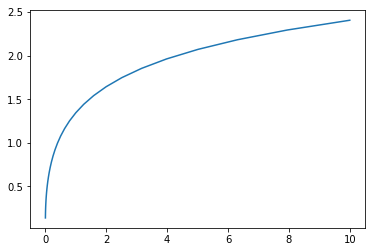

In [182]:
plt.plot(ts, p_inf_new)

In [183]:
t1 = time()
p_nnnn_new = []
for t in ts:
    p_nnnn_new.append(new_well_nnnn_1.pw(t))
print(time() - t1)

1.8475120067596436


In [184]:
t1 = time()
p_nnnn_new = []
for t in ts:
    p_nnnn_new.append(new_well_nnnn_5.pw(t))
print(time() - t1)

80.79504346847534


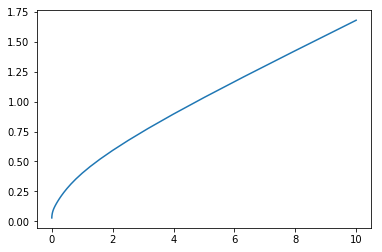

In [85]:
plt.plot(ts, p_nnnn_new)

## Try to improve speed

In [8]:
# made dlm in fb2 - slightly improved speed from 6.18 to 4.63 s /41 pts

In [88]:
arg_x_0, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4 = new_well_nnnn.lapl_well.matrixizer.m_cache["fb_1_2_nnnn"]
u = 7

In [114]:
from new_struct.integrators.frac_nnnn import ifb2, ifb2_k
import pstats, cProfile

In [115]:
u = 7
k = 1
%timeit -n1 -r1000 ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
%timeit -n1 -r1000 ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)

740 µs ± 28.6 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)
24.2 ms ± 371 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)


In [19]:
cProfile.runctx("ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri May 24 07:05:00 2019    Profile.prof

         341 function calls in 0.009 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       30    0.008    0.000    0.009    0.000 frac_nnnn.py:47(ifb2_k)
       30    0.000    0.000    0.001    0.000 frac_nnnn.py:101(calc_sexp)
        1    0.000    0.000    0.009    0.009 frac_nnnn.py:26(ifb2)
       30    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       33    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
       30    0.000    0.000    0.000    0.000 fromnumeric.py:69(_wrapreduction)
       30    0.000    0.000    0.000    0.000 fromnumeric.py:1966(sum)
        1    0.000    0.000    0.009    0.009 {built-in method builtins.exec}
        6    0.000    0.000    0.000    0.000 linalg.py:2293(norm)
        4    0.000    0.000    0.000    0.000 {built-in method numpy.copyto}
        6    0.000    0.000    0.000    0.000 {built-in met

## Try Cython

In [20]:
import cython

In [15]:
def np_naive_convolve(f, g):
    # f is an image and is indexed by (v, w)
    # g is a filter kernel and is indexed by (s, t),
    #   it needs odd dimensions
    # h is the output image and is indexed by (x, y),
    #   it is not cropped
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    # smid and tmid are number of pixels between the center pixel
    # and the edge, ie for a 5x5 filter they will be 2.
    #
    # The output size is calculated by adding smid, tmid to each
    # side of the dimensions of the input image.
    vmax = f.shape[0]
    wmax = f.shape[1]
    smax = g.shape[0]
    tmax = g.shape[1]
    smid = smax // 2
    tmid = tmax // 2
    xmax = vmax + 2 * smid
    ymax = wmax + 2 * tmid
    # Allocate result image.
    h = np.zeros([xmax, ymax], dtype=f.dtype)
    # Do convolution
    for x in range(xmax):
        for y in range(ymax):
            # Calculate pixel value for h at (x,y). Sum one component
            # for each pixel (s, t) of the filter g.
            s_from = max(smid - x, -smid)
            s_to = min((xmax - x) - smid, smid + 1)
            t_from = max(tmid - y, -tmid)
            t_to = min((ymax - y) - tmid, tmid + 1)
            value = 0
            for s in range(s_from, s_to):
                for t in range(t_from, t_to):
                    v = x - smid + s
                    w = y - tmid + t
                    value += g[smid - s, tmid - t] * f[v, w]
            h[x, y] = value
    return h

In [21]:
%load_ext cython

In [17]:
%%cython
# tag: numpy_old
# You can ignore the previous line.
# It's for internal testing of the cython documentation.

import numpy as np

# "cimport" is used to import special compile-time information
# about the numpy module (this is stored in a file numpy.pxd which is
# currently part of the Cython distribution).
cimport numpy as np

# We now need to fix a datatype for our arrays. I've used the variable
# DTYPE for this, which is assigned to the usual NumPy runtime
# type info object.
DTYPE = np.int

# "ctypedef" assigns a corresponding compile-time type to DTYPE_t. For
# every type in the numpy module there's a corresponding compile-time
# type with a _t-suffix.
ctypedef np.int_t DTYPE_t

# "def" can type its arguments but not have a return type. The type of the
# arguments for a "def" function is checked at run-time when entering the
# function.
#
# The arrays f, g and h is typed as "np.ndarray" instances. The only effect
# this has is to a) insert checks that the function arguments really are
# NumPy arrays, and b) make some attribute access like f.shape[0] much
# more efficient. (In this example this doesn't matter though.)
def naive_convolve(np.ndarray[DTYPE_t, ndim=2] f, np.ndarray[DTYPE_t, ndim=2] g):
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    assert f.dtype == DTYPE and g.dtype == DTYPE

    # The "cdef" keyword is also used within functions to type variables. It
    # can only be used at the top indentation level (there are non-trivial
    # problems with allowing them in other places, though we'd love to see
    # good and thought out proposals for it).
    #
    # For the indices, the "int" type is used. This corresponds to a C int,
    # other C types (like "unsigned int") could have been used instead.
    # Purists could use "Py_ssize_t" which is the proper Python type for
    # array indices.
    cdef int vmax = f.shape[0]
    cdef int wmax = f.shape[1]
    cdef int smax = g.shape[0]
    cdef int tmax = g.shape[1]
    cdef int smid = smax // 2
    cdef int tmid = tmax // 2
    cdef int xmax = vmax + 2 * smid
    cdef int ymax = wmax + 2 * tmid
    cdef np.ndarray[DTYPE_t, ndim=2] h = np.zeros([xmax, ymax], dtype=DTYPE)
    cdef int x, y, s, t, v, w

    # It is very important to type ALL your variables. You do not get any
    # warnings if not, only much slower code (they are implicitly typed as
    # Python objects).
    cdef int s_from, s_to, t_from, t_to

    # For the value variable, we want to use the same data type as is
    # stored in the array, so we use "DTYPE_t" as defined above.
    # NB! An important side-effect of this is that if "value" overflows its
    # datatype size, it will simply wrap around like in C, rather than raise
    # an error like in Python.
    cdef DTYPE_t value
    for x in range(xmax):
        for y in range(ymax):
            s_from = max(smid - x, -smid)
            s_to = min((xmax - x) - smid, smid + 1)
            t_from = max(tmid - y, -tmid)
            t_to = min((ymax - y) - tmid, tmid + 1)
            value = 0
            for s in range(s_from, s_to):
                for t in range(t_from, t_to):
                    v = x - smid + s
                    w = y - tmid + t
                    value += g[smid - s, tmid - t] * f[v, w]
            h[x, y] = value
    return h

In [ ]:
%%cython -a
cimport numpy as np
import numpy as np

def c_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed, dlm = None):
    blk_size = 10
    MAXITER = 1000
    TINY = 1e-20
    EPS = 1e-12
    sum_ = np.zeros_like(arg_x_1)
    if dlm is None:
        dlm = 0.
    for i in range(MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.zeros_like(arg_x_1)
        for k in blk:
            d += ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
        sum_ += d
        if np.linalg.norm(d)/(np.linalg.norm(sum_)+ dlm + TINY) < EPS:
            return sum_
    return sum_

def ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed):
    ek = (u + k*k*np.pi*np.pi/xed/xed)**0.5
    sexp = calc_sexp(ek, yed)
    p1 = 2./k/ek*np.cos(k*arg_x_1) # arg_x_1
    p1 *= np.sin(k*arg_x_2) # arg_x_2
    p1 *= np.cos(k*arg_x_3) # arg_x_3
    p1 *= (np.exp(-ek*arg_y_1) + np.exp(-ek*arg_y_2) + np.exp(-ek*arg_y_3))*(1 + sexp) + np.exp(-ek*arg_y_4)*sexp # arg_y_1, arg_y_2, arg_y3, arg_y_4
    return p1

def calc_sexp(ek, yed):
    ek_ = ek*yed
    MAXITER = 300
    blk_size = 3
    TINY = 1e-20
    EPS = 1e-12
    sum_ = 0.
    for i in range(1, MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.sum(np.exp(-2*blk*ek_))
        sum_ += d
        if d/(sum_ + TINY) < EPS:
            return sum_
    return sum_

In [23]:
def calc_sexp(ek, yed):
    ek_ = ek*yed
    MAXITER = 300
    blk_size = 3
    TINY = 1e-20
    EPS = 1e-12
    sum_ = 0.
    for i in range(1, MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.sum(np.exp(-2*blk*ek_))
        sum_ += d
        if d/(sum_ + TINY) < EPS:
            return sum_
    return sum_

In [130]:
%%cython -a
cimport numpy as np
import numpy as np
from numpy import sin as nsin, cos as ncos, exp as nexp
from numpy.linalg import norm
from libc.math cimport exp, sin, cos, sqrt

cdef double c_calc_sexp(double ek, double yed):
    cdef double ek_ = ek*yed
    cdef double d
    cdef int MAXITER = 1000
    cdef int blk_size = 3
    cdef double TINY = 1e-20
    cdef double EPS = 1e-12
    cdef double sum_ = 0.
    cdef int i
    cdef int m
    for i in range(1, MAXITER+1):
        d = 0.
        for m in range(1+i*blk_size, 1+(i+1)*blk_size):
            d += exp(-2*m*ek_)
        sum_ += d
        if d < EPS*(sum_ + TINY):
            return sum_
    return sum_

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cdef np.ndarray[DTYPE_t, ndim=2] cn_cos(np.ndarray[DTYPE_t, ndim=2] arg_x):
    return ncos(arg_x)

cdef np.ndarray[DTYPE_t, ndim=2] cn_ifb2_k(int k, double u,
             np.ndarray[DTYPE_t, ndim=2] arg_x_1,
             np.ndarray[DTYPE_t, ndim=2] arg_x_2,
             np.ndarray[DTYPE_t, ndim=2] arg_x_3,
             np.ndarray[DTYPE_t, ndim=2] arg_y_1,
             np.ndarray[DTYPE_t, ndim=2] arg_y_2,
             np.ndarray[DTYPE_t, ndim=2] arg_y_3,
             np.ndarray[DTYPE_t, ndim=2] arg_y_4,
             double xed, double yed):
    cdef double pi = np.pi
    cdef double ek = sqrt(u + k*k*pi*pi/xed/xed)
    cdef double sexp = c_calc_sexp(ek, yed)
    cdef Py_ssize_t imax = arg_x_1.shape[0]
    cdef Py_ssize_t jmax = arg_x_1.shape[1]
    cdef np.ndarray[DTYPE_t, ndim=2] p1
    p1 = 2./k/ek*cn_cos(k*arg_x_1)
    p1 *= nsin(k*arg_x_2)
    p1 *= cn_cos(k*arg_x_3)
    p1 *= (nexp(-ek*arg_y_1) +\
           nexp(-ek*arg_y_2) +\
           nexp(-ek*arg_y_3))*(1 + sexp) +\
        nexp(-ek*arg_y_4)*sexp
    return p1

def cn_ifb2(double u,
           np.ndarray[DTYPE_t, ndim=2] arg_x_1,
           np.ndarray[DTYPE_t, ndim=2] arg_x_2,
           np.ndarray[DTYPE_t, ndim=2] arg_x_3,
           np.ndarray[DTYPE_t, ndim=2] arg_y_1,
           np.ndarray[DTYPE_t, ndim=2] arg_y_2,
           np.ndarray[DTYPE_t, ndim=2] arg_y_3,
           np.ndarray[DTYPE_t, ndim=2] arg_y_4,
           double xed, double yed,
           double dlm = 0.):
    cdef int blk_size = 10
    cdef int MAXITER = 1000
    cdef double TINY = 1e-20
    cdef double EPS = 1e-12
    cdef int i, k
    cdef Py_ssize_t imax = arg_x_1.shape[0]
    cdef Py_ssize_t jmax = arg_x_1.shape[1]
    cdef np.ndarray[DTYPE_t, ndim=2] sum_ = np.zeros([imax, jmax], dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim=2] d
    for i in range(MAXITER):
        d =  np.zeros([imax, jmax], dtype=DTYPE)
        for k in range(1+i*blk_size, 1+(i+1)*blk_size):
            d += cn_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
        sum_ += d
        if norm(d) < EPS*(norm(sum_)+ dlm + TINY):
            return sum_
    return sum_

In [31]:
ek = (u + k*k*np.pi*np.pi/xed/xed)**0.5

In [92]:
np.allclose(ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed), cn_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed))

True

In [34]:
%timeit -n100000 -r1 calc_sexp(ek, yed)
%timeit -n100000 -r1 c_calc_exp(ek, yed) 

7.29 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
130 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)


In [89]:
u = 0.001
k = 1
%timeit -n1000 -r3 ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
%timeit -n1000 -r3 c_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
%timeit -n1000 -r3 cn_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)

721 µs ± 1.78 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
4.28 ms ± 9.85 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)
631 µs ± 1.08 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [106]:
def calc_matr_fun_arg(np_func_1d, arg, matr):
    orig_shape = matr.shape
    u, i = np.unique(matr, return_inverse=True)
    fu = np_func_1d(arg*u)
    return fu[i].reshape(orig_shape)

In [107]:
from numpy import sin as nsin, cos as ncos, exp as nexp

In [110]:
%timeit -n1000 -r3 nsin(k*arg_x_1)
%timeit -n1000 -r3 calc_matr_fun_arg(nsin, k, arg_x_1)

59.5 µs ± 298 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)
859 µs ± 965 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [129]:
%timeit -n100 -r3 ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
%timeit -n100 -r3 cn_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)

17.9 ms ± 15.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
15.6 ms ± 33.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [123]:
cProfile.runctx("ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri May 24 08:42:34 2019    Profile.prof

         230 function calls in 0.021 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    0.019    0.001    0.019    0.001 frac_nnnn.py:47(ifb2_k)
        1    0.001    0.001    0.021    0.021 frac_nnnn.py:26(ifb2)
       20    0.000    0.000    0.001    0.000 frac_nnnn.py:101(calc_sexp)
        3    0.000    0.000    0.000    0.000 {built-in method numpy.copyto}
       20    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        4    0.000    0.000    0.000    0.000 {built-in method numpy.dot}
       22    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
       20    0.000    0.000    0.000    0.000 fromnumeric.py:69(_wrapreduction)
       20    0.000    0.000    0.000    0.000 fromnumeric.py:1966(sum)
        4    0.000    0.000    0.000    0.000 linalg.py:2293(norm)
        1    0.000    0.000    0.021    0.021 {built-in method 

In [157]:
cProfile.runctx("new_well_nnnn_1.lapl_well.pw(u)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri May 24 11:11:38 2019    Profile.prof

         410 function calls in 0.007 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    0.005    0.000    0.005    0.000 frac_nnnn.py:47(ifb2_k)
        1    0.001    0.001    0.001    0.001 frac_nnnn.py:18(ifb1)
       10    0.000    0.000    0.000    0.000 matrixizer.py:173(reconstruct_dyds_0)
       21    0.000    0.000    0.000    0.000 frac_nnnn.py:101(calc_sexp)
       10    0.000    0.000    0.000    0.000 common.py:5(i_frac_0)
        1    0.000    0.000    0.006    0.006 frac_nnnn.py:26(ifb2)
       22    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 linalg.py:327(solve)
       10    0.000    0.000    0.001    0.000 frac_nnnn.py:78(ifb3_k)
       22    0.000    0.000    0.000    0.000 fromnumeric.py:69(_wrapreduction)
       23    0.000    0.000    0.000    0.000 {built-in method numpy.ara

In [158]:
cProfile.runctx("new_well_nnnn_5.lapl_well.pw(u)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri May 24 11:11:56 2019    Profile.prof

         102936 function calls (102926 primitive calls) in 0.201 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    63084    0.134    0.000    0.134    0.000 common.py:13(frac_fun)
     3004    0.019    0.000    0.153    0.000 {built-in method scipy.integrate._quadpack._qagse}
       20    0.018    0.001    0.018    0.001 frac_nnnn.py:47(ifb2_k)
       10    0.004    0.000    0.175    0.018 shape_base.py:270(apply_along_axis)
     3004    0.003    0.000    0.163    0.000 common.py:9(i_frac_nnz)
     3004    0.003    0.000    0.160    0.000 quadpack.py:44(quad)
     3046    0.003    0.000    0.003    0.000 {built-in method numpy.array}
     3004    0.002    0.000    0.155    0.000 quadpack.py:430(_quad)
       10    0.001    0.000    0.002    0.000 matrixizer.py:182(reconstruct_dyds_nnz)
     3014    0.001    0.000    0.002    0.000 index_tricks.py:653(__next__)
     3004    0.001  

In [185]:
new_well_nnnn_5.lapl_well.matrixizer.m_cache["dyds_nnz"].keys()

dict_keys(['0-', '0+', '1-', '1+', '-1-', '-1+', '2-', '2+', '-2-', '-2+', '3-', '3+', '-3-', '-3+', '4-', '4+', '-4-', '-4+', '5-', '5+', '-5-', '-5+', '6-', '6+', '-6-', '-6+', '7-', '7+', '-7-', '-7+', '8-', '8+', '-8-', '-8+', '9-', '9+', '-9-', '-9+', '10-', '10+', '-10-', '-10+', '11-', '11+', '-11-', '-11+'])

In [162]:
unique_lims_dyd_nnz.shape

(316, 3)

In [187]:
inds_dyds_nnz.shape

(32000,)

In [189]:
inverse_inds_dyd_nnz.shape

(32000,)

In [ ]:
'''
TRY TO REIMPLEMENT THIS PART OF CODE USING CYTHON
    if inds_dyds_nnz is not None:
        f = lambda t: i_frac_nnz(t, su)
        vals_dyds_nnz = np.apply_along_axis(f, 1, unique_lims_dyd_nnz)
        matrixizer.reconstruct_dyds_nnz(m, inds_dyds_nnz, vals_dyds_nnz, inverse_inds_dyd_nnz)
        
        
def i_frac_nnz(x, su):
    upper_lim, dx, dyd = x[0], x[1], x[-1]
    return quad(frac_fun, su*(upper_lim-dx), su*upper_lim, args=(dyd, su))[0]
    
def frac_fun(x, dyd, su):
    return 0.5/su*k0((x*x + su*su*dyd*dyd)**0.5)
'''

In [167]:
# Python version first
from new_struct.integrators.common import i_frac_nnz, frac_fun

In [169]:
su = u **0.5
f = lambda t: i_frac_nnz(t, su)
%timeit -n100 -r10 np.apply_along_axis(f, 1, unique_lims_dyd_nnz)

14.7 ms ± 166 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [205]:
%%cython

cimport numpy as np
import numpy as np
from scipy.special import k0, iti0k0
from scipy.integrate import quad
from libc.math cimport sqrt, log, fabs, exp

ctypedef np.double_t DTYPE_t
DTYPE = np.double

cdef double bessi0(double x):
    cdef double ax, ans, y
    ax = fabs(x)
    if ax < 3.75:
        y = x/3.75
        y*=y
        ans=1.0+y*(3.5156229+y*(3.0899424+y*1.2067492+y*(0.2659732+y*(0.360768e-1+y*0.45813e-2))))
    else:
        y = 3.75/ax
        ans = y*(-0.1647633e-1+y*0.392377e-2)
        ans = 0.916281e-2+y*(-0.2057706e-1+y*(0.2635537e-1+ans))
        ans = 0.225319e-2+y*(-0.157565e-2+y*ans)
        ans = 0.39894228+y*(0.1328592e-1+y*ans)
        ans *= (exp(ax)/sqrt(ax))
    return ans
        
cdef double bessk0(double x):
    cdef double y, ans
    if x <= 2.:
        y = x*x/4.0
        ans=(-log(x/2.0)*bessi0(x))+(-0.57721566+y*(0.42278420+\
            y*(0.23069756+y*(0.3488590e-1+y*(0.262698e-2+\
            y*(0.10750e-3+y*0.74e-5))))))
    else:
        y=2./x
        ans=(exp(-x)/sqrt(x))*(1.25331414+y*(-0.7832358e-1+\
            y*(0.2189568e-1+y*(-0.1062446e-1+y*(0.587872e-2+\
            y*(-0.251540e-2+y*0.53208e-3))))))
    return ans
        
cdef double c_frac_fun(double x, double dyd, double su):
    return 0.5/su*bessk0(sqrt(x*x + su*su*dyd*dyd))

cdef double ci_frac_nnz(double upper_lim, double dx, double dyd, double su):
    return quad(c_frac_fun, su*(upper_lim - dx), su*upper_lim, args=(dyd, su))[0]

cdef np.ndarray[DTYPE_t, ndim=1] integrate_over_uniques_nnnn(double su, np.ndarray[DTYPE_t, ndim=2] uniques):
    cdef Py_ssize_t I, J, i, j
    I = uniques.shape[0]
    J = uniques.shape[1]
    cdef double upper_lim, dx, dyd
    cdef np.ndarray[DTYPE_t, ndim=1] ans = np.zeros([I], dtype=DTYPE)
    for i in range(I):
        upper_lim = uniques[i,0]
        dx = uniques[i,1]
        dyd = uniques[i,2]
        ans[i] = ci_frac_nnz(upper_lim, dx, dyd, su)
    return ans

def reconstruct_dyd_nnz(double su,
                        np.ndarray[DTYPE_t, ndim=2] m,
                        np.ndarray[long, ndim=1] inds_dyds_nnz,
                        np.ndarray[DTYPE_t, ndim=2] unique_lims_dyds_nnz,
                        np.ndarray[long, ndim=1] inverse_inds_dyd_nnz):
    cdef np.ndarray[DTYPE_t, ndim=1] uvals = integrate_over_uniques_nnnn(su, unique_lims_dyds_nnz)
    cdef np.ndarray[DTYPE_t, ndim=1] m_ = m.reshape(-1)
    cdef int sh0 = m.shape[0]
    cdef int sh1 = m.shape[1]
    m_[inds_dyds_nnz] = uvals[inverse_inds_dyd_nnz]
    return m_.reshape(sh0,sh1)
        

In [210]:
def py_reconstruct_dyd_nnz(su, m, inds_dyds_nnz, unique_lims_dyd_nnz, inverse_inds_dyd_nnz):
    orig_shape = m.shape
    f = lambda t: i_frac_nnz(t, su)
    vals_dyds_nnz = np.apply_along_axis(f, 1, unique_lims_dyd_nnz)
    m_ = m.reshape(-1)
    m_[inds_dyds_nnz] = vals_dyds_nnz[inverse_inds_dyd_nnz]
    m_ = m_.reshape(orig_shape)
    return m_

In [207]:
orig_shape = (2*N*5, 2*N*5)
m = np.zeros(orig_shape, dtype=np.double)
su = u**0.5
inds_dyds_nnz, unique_lims_dyd_nnz, inverse_inds_dyd_nnz =\
    new_well_nnnn_5.lapl_well.matrixizer.m_cache["dyds_nnz"]['11+']

In [211]:
%timeit -n100 -r10 reconstruct_dyd_nnz(su, m, inds_dyds_nnz, unique_lims_dyd_nnz, inverse_inds_dyd_nnz)
%timeit -n100 -r10 py_reconstruct_dyd_nnz(su, m, inds_dyds_nnz, unique_lims_dyd_nnz, inverse_inds_dyd_nnz)

1.56 ms ± 4.56 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
19.4 ms ± 117 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [ ]:
'''
    if inds_dyds_nnz is not None:
        f = lambda t: i_frac_nnz(t, su)
        vals_dyds_nnz = np.apply_along_axis(f, 1, unique_lims_dyd_nnz)
        matrixizer.reconstruct_dyds_nnz(m, inds_dyds_nnz, vals_dyds_nnz, inverse_inds_dyd_nnz)
'''